In [168]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

Accuracy: 0.7782240071396698


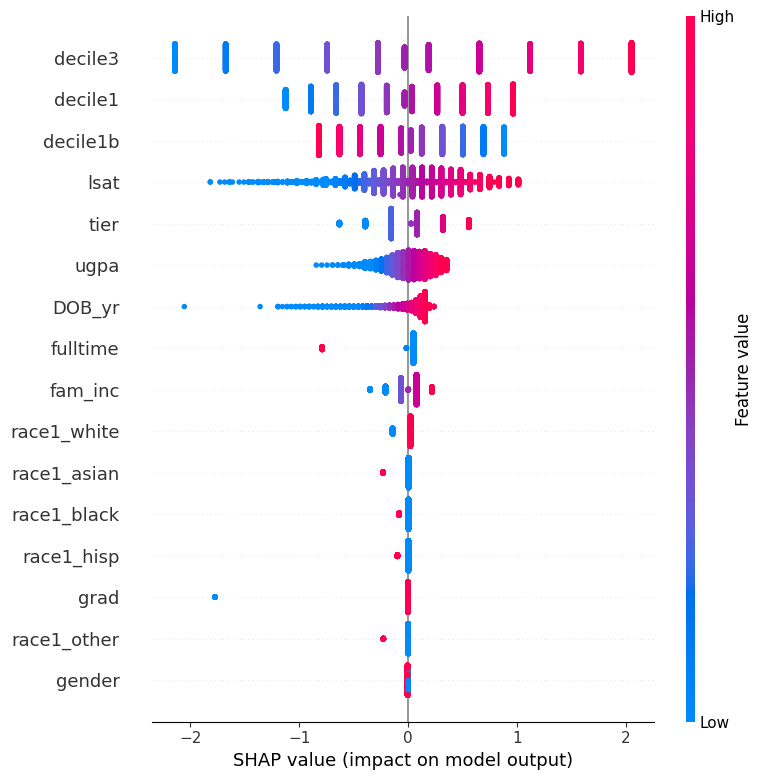

In [169]:

# Load the data
X_train = pd.read_csv('data/X_train_non_scaled.csv', index_col=0)
X_test = pd.read_csv('data/X_test_non_scaled.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0)
y_test = pd.read_csv('data/y_test.csv', index_col=0)

# Ensure y_train and y_test are Series
y_train = y_train.iloc[:, 0]
y_test = y_test.iloc[:, 0]

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame with the original index
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Train a logistic regression model
model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
model.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train_scaled, model_output="probability")

# Compute SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)


In [170]:
fair_PCA_test = pd.read_csv('data/X_test_fair_PCA.csv', index_col=0)
print(fair_PCA_test.index)


Index([ 2489, 10988, 16812, 17067, 10516, 20761,   927,  6836,  8337, 20697,
       ...
       16085,  3260, 16446, 19382, 13510, 18130, 20600,  5500, 15958, 17502],
      dtype='int64', length=4482)


In [171]:

# Ensure gender filtering uses the original non-scaled data
indexes_with_gender_1 = X_test[X_test['gender'] == 1].index

# Filter the scaled test data using the indices
X_test_filtered = X_test_scaled.loc[indexes_with_gender_1]

# Predict probabilities for the filtered data
probabilities = model.predict_proba(X_test_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff = np.abs(probabilities[:, 0] - probabilities[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_data_with_probs = pd.DataFrame(
    np.column_stack((X_test_filtered.values, probabilities, prob_diff)),
    columns=X_test_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=X_test_filtered.index  # Preserve original indices
)

# Sort the data by the absolute difference between the class probabilities
sorted_filtered_data = filtered_data_with_probs.sort_values(by='prob_diff')

# Output the top 10 data points where the probabilities are most balanced
top_10_balanced = sorted_filtered_data.head(10)

# Display the probabilities for the top 10 balanced data points
for index, row in top_10_balanced.iterrows():
    print(f"Index: {index}, Probabilities: Class 0 = {row['prob_class_0']:.4f}, Class 1 = {row['prob_class_1']:.4f}")

# Load fair PCA data for further analysis
fair_PCA_test = pd.read_csv('data/X_test_fair_PCA.csv', index_col=0)

# Optionally check if indices in `top_10_balanced` are present in `fair_PCA_test`
missing_indices = [idx for idx in top_10_balanced.index if idx not in fair_PCA_test.index]
if missing_indices:
    print("Missing indices in fair_PCA_test:", missing_indices)
else:
    print("All indices are present in fair_PCA_test.")


Index: 6073, Probabilities: Class 0 = 0.5002, Class 1 = 0.4998
Index: 5777, Probabilities: Class 0 = 0.5005, Class 1 = 0.4995
Index: 2692, Probabilities: Class 0 = 0.5005, Class 1 = 0.4995
Index: 10432, Probabilities: Class 0 = 0.5006, Class 1 = 0.4994
Index: 1948, Probabilities: Class 0 = 0.5010, Class 1 = 0.4990
Index: 20360, Probabilities: Class 0 = 0.4988, Class 1 = 0.5012
Index: 12027, Probabilities: Class 0 = 0.4988, Class 1 = 0.5012
Index: 11959, Probabilities: Class 0 = 0.4975, Class 1 = 0.5025
Index: 18971, Probabilities: Class 0 = 0.5025, Class 1 = 0.4975
Index: 1301, Probabilities: Class 0 = 0.4973, Class 1 = 0.5027
All indices are present in fair_PCA_test.


In [174]:
# Get the indices of the top 10 balanced data points
indices_of_interest = top_10_balanced.index

# Filter the Fair PCA test data
fair_PCA_filtered = fair_PCA_test.loc[indices_of_interest]


In [175]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming 'model' is already trained
# Predict probabilities on the filtered Fair PCA test data
probabilities_fair_pca = model.predict_proba(fair_PCA_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff_fair_pca = np.abs(probabilities_fair_pca[:, 0] - probabilities_fair_pca[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_fair_pca_with_probs = pd.DataFrame(
    np.column_stack((fair_PCA_filtered, probabilities_fair_pca, prob_diff_fair_pca)),
    columns=fair_PCA_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=indices_of_interest
)

# Display the DataFrame with probabilities and difference
print(filtered_fair_pca_with_probs)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 0
- 1
- 2
- 3
- 4
Feature names seen at fit time, yet now missing:
- DOB_yr
- decile1
- decile1b
- decile3
- fam_inc
- ...
